In [368]:
def spatial_decomposition(X, unit_cell, *args):
    '''
    % decomposite the spatial domain into cells D with vertices V,
    %
    % Output
    %  V - list of vertices
    %  F - list of faces
    %  I_FD - incidence matrix between faces to cells

    % compute voronoi decomposition
    % V - list of vertices of the Voronoi cells
    % D   - cell array of Vornoi cells with centers X_D ordered accordingly
    '''
    # Imports
    import getopt
    from numpy import cumsum, zeros, unique, sort
    from spatialDecompFunctions import generateUnitCells
    from scipy.spatial import Voronoi
    from scipy.sparse import csr_matrix, coo_array
    from orix.utilities.utilities import uniquerows

    if unit_cell.all() == None:
        unit_cell = calcUnitCell(X)

    if args[0] == 'unit_cell':

        # compute the vertices
        [V, faces] = generateUnitCells(X, unit_cell, args[:])
        # NOTE: V and faces do not give exact values as compared to the MATLAB
        # implementation. However, Eric and Rohan have confirmed that V and faces
        # at least have the same shape as the MATLAB implementation.

        D = np.empty(len(X),dtype=object)

        for k in range(X.shape[0]):
            D[k] = faces[k, :]

    else:    
        var_arg_in = args[0]
        dummy_coordinates = calcBoundary(X, unit_cell, var_arg_in)
        
        vor = Voronoi(np.vstack([X, dummy_coordinates]), 
                        qhull_options = 'Q5 Q6 Qs') #,'QbB'

        V = vor.vertices
        D = vor.regions
        D = D[0:X.shape[0]]

    # now we need some adjacencies and incidences
    iv = np.hstack(D)        # nodes incident to cells D
    iid = zeros(len(iv), dtype=np.int64)   # number the cells

    # Some MATLAB stuff goin on here... : p = [0; cumsum(cellfun('prodofsize',D))];
    D_prod = matlab_prod_of_size(D)
    p = np.hstack([0, np.cumsum(D_prod)-1])

    # original matlab: for k=1:numel(D), id(p(k)+1:p(k+1)) = k; end
    for k in range(len(D)):
        iid[p[k]+1 : p[k+1]] = k

    # next vertex
    # indx = 2:numel(iv)+1;
    ind_x = np.arange(1,len(iv)+1)
    # indx(p(2:end)) = p(1:end-1)+1;
    ind_x[p[1:]] = p[0:-1] + 1
    # ivn = iv(indx);
    iv_n = iv[ind_x]

    # edges list
    F = np.vstack([iv[:], iv_n[:]]).T

    # should be unique (i.e one edge is incident to two cells D)
    F, _, ie = uniquerows(F)

    # faces incident to cells, F x D
    #original matlab: I_FD = sparse(ie,id,1); 
    # Matlab stores as csr matrix, so we use this class below
    data = np.ones(np.shape(ie))
    I_FD = csr_matrix( (data, (ie, iid)))
    #I_FD = csr_matrix( (data, (ie, iid)), shape=[ie.shape[0], ie.shape[0]]) # could also use csc_matrix() if it improves
                                # performance !
    '''
    NOTE: may need to use different sparse matrix. The matrix is incorrect as
          compared to the MATLAB implementation.
          
          Could also be causing problems in the Householder matrix initialization.
    '''
    

    return V, F, I_FD

def calcBoundary(X, unit_cell, var_arg_in='hull'):
    '''
    dummy coordinates so that the voronoi-cells of X are finite

    Inputs:
    --------------
    X : n x 2 numpy array of [x,y] vertex coordinates

    unit_cell : n x 2 numpy array of [x,y] coordinates of "pixel" boundary (e.g. hexagon or square)

    var_arg_in : ???
    ???


    Outputs:
    --------------
    ??? : ???
    ???

    Dependencies:
    --------------
    import getopt
    import numpy as np
    from scipy.spatial import ConvexHull
    from numpy import arctan2, diff, cumsum, matrix, squeeze, unique
    from statistics import mean
    from math import sqrt, floor, copysign
    '''
    # Imports
    import getopt
    import numpy as np
    from scipy.spatial import ConvexHull
    from numpy import arctan2, cumsum, matrix, squeeze, unique, linspace
    from statistics import mean
    from math import sqrt, floor, copysign
    from orix.quaternion.rotation import Rotation
    import orix.vector as vect
    from orix.utilities.utilities import uniquerows
    from matplotlib import path
    
    from spatialDecompFunctions import householderMatrix, translationMatrix#, erase_linearly_dependent_points

    dummy_coordinates = []

    boundary = 'hull'
    boundary = str(var_arg_in)

    if boundary.isalpha():

        if (boundary.lower() == 'hull' or
            boundary.lower() == 'convexhull'):
            
            bounding_X  = erase_linearly_dependent_points(X)
            
            import matplotlib.pyplot as plt
            plt.figure()
            plt.plot(bounding_X[:,0], bounding_X[:,1])
            plt.show()
            
        elif boundary.lower() == 'cube':
            # set up a rectangular box
            envelope_X = [np.amin(X), np.amax(X)]
            bounding_X = [
                envelope_X[1], envelope_X[3],
                envelope_X[2], envelope_X[3],
                envelope_X[2], envelope_X[4],
                envelope_X[1], envelope_X[4],
                envelope_X[1], envelope_X[3],
                ]

        else:
            raise ValueError('Unknown boundary type. Available options are \
            ''hull'', ''convexhull'' and ''cube''.')

    elif isinstance(boundary, float):
        bounding_X = boundary
    
    radius = np.mean(np.sqrt(np.sum( (unit_cell**2), axis=1)))
    
    edge_length = ((matlabdiff(bounding_X)**2).sum(axis=1, keepdims=True))**0.5 
    #edgeLength = sqrt(sum(diff(boundingX).^2,2));
    
    # fill each line segment with nodes every 20 points (in average)
    nto = np.int32(np.fix( (edge_length>0)*4 ))

    #nto = floor( edge_length*(2*radius) )
    #nto = fix((edgeLength>0)*4); fix(edgeLength*(2*radius));

    csum = np.int32(cumsum(np.vstack([0, nto+1])))

    bounding_X = left_hand_assignment(bounding_X, csum)
    
    # interpolation
    for k in range(nto.shape[0]):
        for dim in range(nto.shape[1]+1):
            bounding_X[csum[k]:csum[k+1]+1, dim] = linspace(
                bounding_X[csum[k],dim],
                bounding_X[csum[k+1], dim],
                nto[k,0]+2
            )

    # homogeneous coordinates
    X = np.hstack([X, np.ones([X.shape[0],1])])
    bounding_X = np.hstack([bounding_X, np.ones([bounding_X.shape[0],1])])

    # direction of the edge
    edge_direction = matlabdiff(bounding_X)
    edge_angle = arctan2( edge_direction[:, 1], edge_direction[:,0] )
    edge_length = np.sqrt( (edge_direction**2).sum(axis = 1, keepdims=True))

    # shift the starting vertex
    r = Rotation.from_axes_angles(vect.Vector3d([0, 0, 1]), edge_angle)
    a = vect.Vector3d([0, radius, 1])
    b_X = np.squeeze(r * a)
    offset_X = np.squeeze(b_X.data) - np.squeeze(bounding_X[0:-1, :])
 
    dummy_coordinates = np.array([[0,0]])
    for k in range(bounding_X.shape[0]-1):

        # mirror the point set X on each edge
        p_X = np.matmul(X,
            -1*( 
                np.matmul(
                    np.matmul(
                        translationMatrix(offset_X[k, :]),
                        householderMatrix(edge_direction[k, :])
                    ), 
                    translationMatrix(offset_X[k, :])
                ).T
            )
        )

        '''
        NOTE FROM ERIC AND ROHAN: We are having problems with getting the proper
        dummy_coordinates. The bounding box only has 2 of 4 lines, we believe
        this is where the problem is. MATLAB is doing bizarre things with the
        element-wise division!!!!! We need to contact somebody about this behavior.
        Python is doing what we expect but it's not the right answer.
        
        UPDATE FROM ERIC: Changing the order of operations in Python gives the same result as Matlab.
        '''

        # distance between original and mirrored point
        dist = np.sqrt(np.sum((X[:,0:-1]-p_X[:,0:-1])**2, axis=1))

        intend_X = 2. * radius * np.sign(edge_direction[k,0:2])

        # now try to delete unnecessary points
        m = 2        
        
        while(True):

            tmp_X = p_X[dist < m*radius, 0:2]

            right = np.matmul(tmp_X - np.tile( bounding_X[k, 0:2]   - intend_X, [np.shape(tmp_X)[0], 1]), edge_direction[k, 0:2].T) < 0
            left  = np.matmul(tmp_X - np.tile( bounding_X[k+1, 0:2] + intend_X, [np.shape(tmp_X)[0], 1]), edge_direction[k, 0:2].T) > 0

            tmp_X = tmp_X[~np.any(np.vstack([right, left]), axis=0), 0:2]
            
            with np.errstate(divide='ignore'):
                if edge_length[k] / tmp_X.shape[0] < radius/3:
                    break
                elif m < 2**7:
                    m = m*2
                elif m < 2**7+100:
                    m = m+10
                else:
                    break
                

        if tmp_X.size > 0:
            dummy_coordinates = np.vstack([dummy_coordinates, tmp_X])

    # Since we initialized dummy_coords with a 0 row, pop it out
    dummy_coordinates = np.delete(dummy_coordinates, 0, axis=0)
    
    # MATLAB implementation used the standard "unique" on a float array
    # Enforced a unique rows with a tolerance of 1e-12 which agrees with
    # MATLAB's "uniquetol" output
    dummy_coordinates = np.unique(dummy_coordinates.round(decimals=12), axis=0)
    
    # Use matplotlib path to check if we left any points in/on the polygon
    # Note, python uses 'FALSE' to delete rows, so inverse the logic returned.
    p = path.Path(bounding_X[:, 0:2])
    dummy_coordinates = dummy_coordinates[~p.contains_points(dummy_coordinates)]

    return dummy_coordinates

def matlab_prod_of_size(D):
    '''
    Testing:
    test1 = [[1, 2, 3], [1, 2], [1]]
    matlab_prod_of_size(test1)
    '''
    prod_of_size = []
    for elem in D:
        prod_of_size.append(len(elem))
    return prod_of_size

def erase_linearly_dependent_points(X):
    '''
    subfunction to remove linearly dependent points.

    Inputs:
    --------------
    k : ???
        ???

    Outputs:
    --------------
    ??? : ???
        ???

    Dependencies:
    --------------
    from scipy.spatial import ConvexHull
    '''
    from orix.utilities.utilities import regularPoly
    import numpy as np
    from scipy.spatial import ConvexHull
    from orix.utilities.utilities import sortrows
    import alphashape
    
    #k = alphashape.alphashape(X, 0.95)
    k = ConvexHull(X)
    #k = k.exterior.coords.xy
    #print(k.shape[0], k.shape[1])
    k = k.vertices

    # erase all linear dependent points
    angle = np.arctan2(X[k[0:-1],0]-X[k[1:],0],
        X[k[0:-1],1]-X[k[1:],1])
    test = np.abs(np.diff(angle))>np.spacing(1.0)
    k2 = k[np.concatenate([[True], test, [True]])]
    
    # Build the coord set of the convex hull
    # Pad on the end->start connection to close hull
    # If the origin is contained as a boundary point
    # then we need to shift the array values so the origin
    # is the end->start wrap
    boundingX = X[k2,:]
    
    zero_row = -1
    for i in range(boundingX.shape[0]):
        if np.all(boundingX[i]==0):
            zero_row = i
    
    if (zero_row != -1):
        boundingX = np.roll(boundingX, -zero_row, axis=0)
    
    boundingX = np.vstack([boundingX , boundingX[0,:] ])
 
    return boundingX

def left_hand_assignment(X, a):
    '''
    Attempts to replicate MATLAB left-hand assignment for a 2D array.
 

    Inputs:
    --------------
    X : 2D numpy array
 

    Outputs:
    --------------
    X : 2D numpy array
        This is different from the X passed in, it will return a larger array with
        more zeros.
 
    Dependencies:
    --------------
    import numpy as np
    '''
 
    import numpy as np
    import warnings
    
    if a.dtype != 'int':
        warnings.warn('parameter ''a'' must be of integer type. Converting ''a'' into integers and moving on...')

    a = np.int32(a)

    bound_X_init = X
    ncols = X.shape[1]
 
    max_a = np.amax(a)
    bound_X_fin = np.zeros([max_a+1, ncols])
  
    bound_X_fin[0:bound_X_init.shape[0], :] = bound_X_init

    for i, elem in enumerate(a[0:-1]):
        bound_X_fin[elem, :] = bound_X_init[i, :]

    return bound_X_fin

def matlabdiff(myArray):
    return myArray[1:,:] - myArray[0:-1,:]

def calcUnitCell(xy, *args):
    '''
    Compute the unit cell for an EBSD data set
    '''
    
    import numpy as np
    from scipy.spatial import Voronoi
    
    # isempty return
    ## NOT WRITTEN
    
    # Check if the input xy is 3-col data and do some recursion
    ## NOT WRITTEN
    
    # Make the first estimate of the grid resolution
    area = (np.max(xy[:,0])-np.min(xy[:,0]))*(np.max(xy[:,1])-np.min(xy[:,1]))
    dxy = np.sqrt(area / np.max(xy.shape))
    
    # Compensate for the single line EBSD
    ## NOT WRITTEN
    
    # Remove the duplicates from the coords
    tol = 0.010 / np.sqrt(xy.shape[0])
    xy = np.unique(xy.round(decimals=6), axis=0) # Need better solution here for uniquetol
    # see https://stackoverflow.com/questions/46101271/what-does-uniquetol-do-exactly
    
    # Reduce the data set
    if (np.max(xy.shape) > 10000):
        xy = subSample(xy, 10000)
    
    # Wrap the Voronoi decomp in a try/catch
    try:
        vor = Voronoi(xy, qhull_options='Qz')
        V = vor.vertices
        D = vor.regions

        # Some notes here: Our V omits the [inf inf] first cell that MATLAB returns
        # but our D does contain the first dead cell that MATLAB omits

        # Try the sorting thing from:
        # https://stackoverflow.com/questions/59090443/how-to-get-the-same-output-of-voronoin-of-matlab-by-scipy-spatial-voronoi-of-pyt

        # Find point coordinate for each region
        sorting = [np.where(vor.point_region==x)[0][0] for x in range(1, len(D))]
        # sort regions along coordinate list `sorting` (exclude first, empty list [])
        sorted_regions = [x for _, x in sorted(zip(sorting, D[1:]))]
        # The above command gives us parity with MATLAB's voronoin
        # but the IDs of the vertices aren't necessarily the same

        # Compute the area of each Voronoi cell
        areaf = np.zeros((np.max(xy.shape)))
        for i, indices in enumerate(sorted_regions):

            # Skip this calculation if open cell
            if -1 in np.array(indices):
                areaf[i] = np.nan          
                continue

            # Retrieve the vertices in this Voronoi cell
            # and compute the area with a shoelace formula
            r_verts = np.vstack([V[indices,:], V[indices[0],:]])
            areaf[i] = polyArea(r_verts[:,0],r_verts[:,1])

        # Now, find the "unit cell" which is the Voronoi cell with the 
        # smallest area. If there are duplicates, grab the first.
        ci = int(np.argwhere(areaf==np.nanmin(areaf))[0])

        # Get the vertices of the "unit cell"
        unitCell = np.array([V[sorted_regions[ci],0] - xy[ci,0], \
                             V[sorted_regions[ci],1] - xy[ci,1]]).transpose()

        # Ignore some points given the grid resolution value
        # It would be helpful is "ignore" was returned as a tuple instead of 2d array
        ignore = np.hstack([np.zeros((1, 1), dtype=bool), [np.sum(np.power(matlabdiff(unitCell),2), axis=1) < dxy/100]])
        unitCell = unitCell[~ignore[0,:],:] # Inversion here since Python deletes False

        # Check if this is a regular polygon
        if (isRegularPoly(unitCell)):      # Missing varargin here
            return unitCell

    except:
        pass

    ## EVERYTHING BELOW HERE IS IF THE VORONOI UNITCELL DOESNT 
    ## END UP CREATING A REGULAR POLYGON UNITCELL
    ## Please code me :)
    
    # Get the second estimate of the grid resolution ?
    ## NOT WRITTEN YET
    
    # Get some grid options
    ## NOT WRITTEN YET - REQUIRES VARARGIN
    
    # Otherwise, do some handling to return a regular unit cell
    # if the previous Voronoi decomp did not
    ## NOT WRITTEN YET - REQUIRES regularPoly to be ported
    
    # return unitCell
    
def subSample(xy, N):
    '''
    Find a square subset of about N points
    '''
    import numpy as np
    
    xminmax = np.vstack([np.min(xy[:,0]), np.max(xy[:,0])])
    yminmax = np.vstack([np.min(xy[:,1]), np.max(xy[:,1])])

    while (np.max(xy.shape) > N):
        
        if (matlabdiff(xminmax) > matlabdiff(yminmax)):
            xminmax = np.divide(np.matmul(np.array([[3, 1], [1, 3]]), xminmax), 4)
        else:
            yminmax = np.divide(np.matmul(np.array([[3, 1], [1, 3]]), yminmax), 4)
        
        log_a = np.logical_and(xy[:,0] > xminmax[0], (xy[:,0] < xminmax[1]))
        log_b = np.logical_and(xy[:,1] > yminmax[0], (xy[:,1] < yminmax[1]))
        log_ab = np.logical_and(log_a, log_b)
        
        xy = xy[log_ab, :]

    return xy    
        
def polyArea(x,y):
    return 0.50*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def polyAreaSigned(x,y):
    return 0.50*np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1))


def isRegularPoly(unitCell):
    
    import numpy as np
    
    # Compute the side lengths of all the "edges"
    sideLength = np.sqrt(np.sum(np.power(unitCell,2), axis=1))
    sides = sideLength.size
    
    # Some complex conversions and a roll
    uC = unitCell[:,0] + unitCell[:,1] * 1.0j
    nC = np.roll(uC, -1, axis=0)
    
    # Determine the angles between the edges
    enclosingAngle = np.divide(uC, nC)
    enclosingAngle = np.abs(np.real(enclosingAngle)) + \
                     np.abs(np.imag(enclosingAngle)) * 1.0j

    # If it is extremely close to a square or hex, we are good to return
    isRegular = (np.any(sides==np.array([4, 6]))) and \
                (np.linalg.norm(enclosingAngle - np.mean(enclosingAngle)) < np.deg2rad(0.05))
    
    return isRegular
    
    

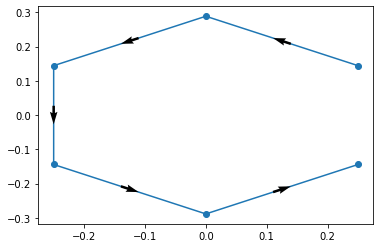

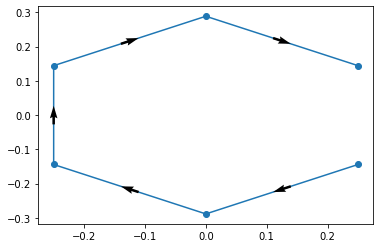

[[ 2.49999220e-01  1.44337117e-01]
 [ 1.76761988e-17  2.88674234e-01]
 [-2.49999220e-01  1.44337117e-01]
 [-2.49999220e-01 -1.44337117e-01]
 [-5.30285965e-17 -2.88674234e-01]
 [ 2.49999220e-01 -1.44337117e-01]]
[[ 0.249999   -0.14433701]
 [ 0.         -0.28867399]
 [-0.249999   -0.14433701]
 [-0.249999    0.14433701]
 [ 0.          0.28867399]
 [ 0.249999    0.14433701]]
-0.32475750009608356
0.3247569509669983


In [369]:
args = (['hull'])

import numpy as np
import matplotlib.pyplot as plt

X = np.loadtxt('spatialDecomposition_input_X.csv', delimiter=',', dtype=float)
unit_cell_matlab = np.loadtxt('spatialDecomposition_input_unitCell.csv', delimiter=',', dtype=float)
unit_cell_python = calcUnitCell(X)

## PLOT 1
x = unit_cell_matlab[:,0]
y = unit_cell_matlab[:,1]

u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/2
pos_y = y[:-1] + v/2
norm = np.sqrt(u**2+v**2) 

fig, ax = plt.subplots()
ax.plot(x,y, marker="o")
ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")
plt.show()

uc_matlab_area = polyAreaSigned(x,y)

## PLOT 2
x = unit_cell_python[:,0]
y = unit_cell_python[:,1]

u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/2
pos_y = y[:-1] + v/2
norm = np.sqrt(u**2+v**2) 

fig, ax = plt.subplots()
ax.plot(x,y, marker="o")
ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")
plt.show()

uc_python_area = polyAreaSigned(x,y)

# They seem to be identical (aside from numerical precision) but reverse ordered (CW vs CCW)
print(unit_cell_matlab)
print(unit_cell_python)

print(uc_matlab_area) # Negative = 
print(uc_python_area)